# Creating videos of GTOC5 trajectories

Luís F. Simões

2017-04

This notebook implements the code used to generate the video shown below.<br>
It animates the trajectory “Spice” (Score: 17) found in the course of the [Beam P-ACO research](https://github.com/lfsimoes/beam_paco__gtoc5). Its specification can be obtained with:

~~~python
from gtoc5.bestiary import spice
~~~

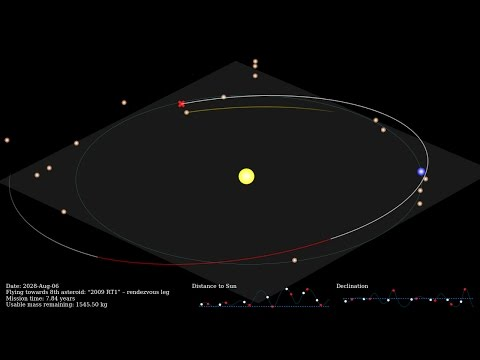

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('WdmbczsFyto', width=853, height=480, rel=0)

----

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

----

# Imports

See the [Watermark](#Watermark) section for the specific versions used of each library.<br>
For the code contained in this notebook to work, Matplotlib has two additional external dependencies:
 * [FFmpeg](https://ffmpeg.org/about.html) (required for the animation module to be able to save output to movie formats), and
 * [ImageMagick](https://www.imagemagick.org/) (required for the animation module to be able to save to animated gif files).

In [2]:
# https://esa.github.io/pykep/
# https://github.com/esa/pykep
# https://pypi.python.org/pypi/pykep/
import PyKEP as pk

In [3]:
import numpy as np

In [4]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 10, 8

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.animation import FuncAnimation

%matplotlib inline
#%matplotlib notebook

In [5]:
import seaborn as sns

In [6]:
import sys
from tqdm import tqdm

In [7]:
from gtoc5 import *

Loading “Spice”, the trajectory being shown.

In [8]:
from gtoc5.bestiary import spice
score(spice), final_mass(spice), tof(spice) * DAY2YEAR, resource_rating(spice)

(17.0, 503.17005813629083, 14.824982263414686, 0.0016809741417111957)

---

# Decoding `mission` data structures

Classes that take in a `mission` data structure (as created by the GTOC5 module's `mission_to_1st_asteroid()` and `add_asteroid()` functions) and rebuild the legs they define. Legs gain additional information about them, along with methods to manipulate that information.

In [9]:
class leg(object):

    def __init__(self, mission, departure_idx):
        """
        Load a GTOC5 leg, as specified in the `mission` data structure,
        at indices `departure_idx` and `departure_idx + 1`.
        """
        (self.dep_ast, self.dep_m, self.dep_t, _,           _) = mission[departure_idx]
        (self.arr_ast, self.arr_m, self.arr_t, self.leg_dT, _) = mission[departure_idx + 1]
        # self.arr_m is mass at the end of the leg, after deploying equipment/penetrator
        # self.arr_t is time of this leg's termination, when spacecraft starts next leg
        self.idx = departure_idx + 1
    
    
    def show(self, ax=None, **kwargs):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        rs = self.where_at(**kwargs) / AU
        ax.plot(rs[:,0], rs[:,1], rs[:,2])
        return ax
        
    
    def destination(self):
        "Name of the asteroid the leg is flying towards"
        name = asteroids[self.arr_ast].name
        if name[0]=='(' and name[-1]==')':
            name = name[1:-1]
        return name
        
    
    def ordinal(self):
        """
        Ordinal representation of the destination asteroid
        in the sequence (1st, 2nd, ...).
        """
        nth = int(np.ceil(self.idx / 2))
        # http://stackoverflow.com/a/739266
        if 4 <= nth <= 20 or 24 <= nth <= 30:
            suffix = "th"
        else:
            suffix = ["st", "nd", "rd"][nth % 10 - 1]
        return '%d%s' % (nth, suffix)
        
    
    def ast_at(self, ast, epochs=None, dTs=None, nr_pts=50):
        """
        Where is the given asteroid `ast` as this leg takes place?
        Time range specified as a list of `epochs` or `dTs`.
        """
        if epochs is None and dTs is None:
            # no epochs nor dTs specified; obtain positions at `nr_pts` points along the leg's duration
            epochs = self.dep_t + np.linspace(0, self.leg_dT, nr_pts)
        elif epochs is None:
            # dTs specified; convert them to epochs
            epochs = [self.dep_t + dT for dT in dTs]
        assert all(self.dep_t <= e <= self.arr_t for e in epochs), \
            "Requested epochs are out of the leg's bounds [%f, %f]" % (self.dep_t, self.arr_t)
        rv = np.array([
            asteroids[ast].eph(pk.epoch(e, 'mjd'))
            for e in epochs
            ]).reshape(-1, 6)
        return rv[:, :3], rv[:,-3:] # (r , v)
    
    
    def precompute_path(self):
        "Precompute path taken by spacecraft along leg at 0.2 day increments."
        self.path_t = np.arange(self.dep_t, self.arr_t, 0.2)
        if self.path_t[-1] < self.arr_t:
            # ensure r is computed at the leg's arrival time
            self.path_t = np.hstack([self.path_t, self.arr_t])
        self.path_r, self.path_v = self.where_at(epochs=self.path_t)
    
    
    def precomputed_path(self, current_epoch, rv=None):
        """
        Read from the precomputed path information the spacecraft's
        path along the current leg, up to `current_epoch`.
        """
        assert self.dep_t <= current_epoch <= self.arr_t, \
            "Requested `current_epoch` lies of the leg's bounds [%f, %f]" % (self.dep_t, self.arr_t)
        r, v = rv if rv is not None else (self.path_r, self.path_v)
        # find index into the precomputed path lying closest to `current_epoch`
        nearest_idx = np.abs(self.path_t - current_epoch).argmin()
        return (self.path_t[:nearest_idx + 1],
                r[:nearest_idx + 1],
                v[:nearest_idx + 1])

In [10]:
class leg_fb(leg):
    
    leg_type = 'self-fly-by'
    
    def __init__(self, mission, departure_idx, precompute_path=False):
        """
        Load a GTOC5 self-flyby leg, as specified in the `mission`
        data structure, at indices `departure_idx` and `departure_idx + 1`.
        """
        super(leg_fb, self).__init__(mission, departure_idx)
        assert self.dep_ast == self.arr_ast, "Given leg is not a self-fly-by leg."
        
        if precompute_path:
            self.precompute_path()
        
    
    def where_at(self, epochs=None, dTs=None, nr_pts=50):
        """
        Where's the spacecraft during this leg, at the given `epochs` or `dTs`?
        
        Self-fly-by legs are approximated by the linear acceleration model.
        No further details about them are available in our chemical version of
        the full-problem. In any case, the spacecraft's movements around the
        asteroid would be imperceptible in the plot. So, we simply return here
        the asteroid's position as representation of the spacecraft's location
        during the self-flyby leg.
        """
        return self.ast_at(self.dep_ast, epochs, dTs, nr_pts)

In [11]:
class leg_rv(leg):
    
    leg_type = 'rendezvous'
    
    def __init__(self, mission, departure_idx, precompute_path=False):
        """
        Rebuild a GTOC5 rendezvous leg, as specified in the `mission`
        data structure, at indices `departure_idx` and `departure_idx + 1`.
        """
        super(leg_rv, self).__init__(mission, departure_idx)
        
        self.leg = gtoc5_rendezvous(self.leg_dT, self.dep_ast, self.arr_ast, self.dep_t, self.dep_m,
                                    validate_barker=False, validate_acc=False)
        # The very first rendezvous leg, departing from Earth, will also be decoded
        # here by a Lambert arc. That leg's specification was actually obtained as
        # the result of a low-thrust optimization (see `mission_to_1st_asteroid()`).
        # For plotting purposes, however, a Lambert arc created using the same relevant
        # epochs will be indistinguishable from the leg's true low-thrust arc.
        
        # leg departs from the asteroid's r at epoch dep_t
        dep_epoch = pk.epoch(float(self.dep_t), 'mjd')
        self.dep_r = self.leg.dep_ast.eph(dep_epoch)[0]
        # velocity vector at departure asteroid given by the chosen Lambert's problem solution
        self.dep_v = self.leg.v_sc[0]
        
        if precompute_path:
            self.precompute_path()
            # determine also where the arrival asteroid is at while rendezvous with it is taking place
            self.arr_ast_r, self.arr_ast_v = self.ast_at(self.arr_ast, epochs=self.path_t)
    
    
    def inspect(self):
        """
        Obtain dictionary of variables defined in the `gtoc5_rendezvous`
        instance (`self.leg`), excluding the asteroids' objects.
        """
        return {k:v for (k,v) in self.leg.__dict__.items() if '_ast' not in k}
    
    
    def propagate_lagrangian(self, dT=None, epoch=None):
        if epoch is not None:
            assert self.dep_t <= epoch <= self.arr_t, \
                "Given epoch (%f) is out of the leg's bounds [%f, %f]" % (
                    epoch, self.dep_t, self.arr_t)
            dT = epoch - self.dep_t
        # https://esa.github.io/pykep/documentation/core.html#PyKEP.propagate_lagrangian
        return pk.propagate_lagrangian(self.dep_r, self.dep_v, dT * DAY2SEC, MU_SUN)
        
    
    def where_at(self, epochs=None, dTs=None, nr_pts=50):
        "Where's the spacecraft during this leg, at the given `epochs` or `dTs`?"
        if epochs is None and dTs is None:
            # no epochs nor dTs specified; obtain positions at `nr_pts` points along the leg's duration
            epochs = self.dep_t + np.linspace(0, self.leg_dT, nr_pts)
        elif epochs is None:
            # dTs specified; convert them to epochs
            epochs = [self.dep_t + dT for dT in dTs]
        rv = np.array([
            self.propagate_lagrangian(epoch=e)
            for e in epochs
            ]).reshape(-1, 6)
        return rv[:, :3], rv[:,-3:] # (r , v)

In [12]:
class bodies(object):
    "Where are all the bodies visited in the mission?"
    
    def __init__(self, mission):
        self.ids = seq(mission, incl_flyby=False)
        self.bodies = [asteroids[b] for b in self.ids]
        self.names = [
            b.name[1:-1] if b.name[0]=='(' and b.name[-1]==')' else b.name
            for b in self.bodies]
    
    def where_at(self, epoch):
        t = pk.epoch(epoch, 'mjd')
        rv = np.array([
            b.eph(t)
            for b in self.bodies
            ]).reshape(-1, 6)
        return rv[:, :3], rv[:,-3:] # (r , v)

In [13]:
#t = [(leg_rv if i % 2 == 0 else leg_fb)(spice, i, precompute_path=True)
#     for i in range(len(spice) - 1)]

In [14]:
# targets, and leg-type at each leg
#[(i, l.destination(), l.leg_type) for i,l in enumerate(t)]

In [15]:
# path taken by spacecraft in the first 5 days of its first leg (epochs, r, v)
#t[0].precomputed_path(t[0].dep_t+5)

In [16]:
#bodies(spice).names

----

# Trajectory animation class

In [17]:
from bisect import bisect_right

# https://docs.python.org/3/library/bisect.html#searching-sorted-lists
def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect_right(a, x)
    if i:
        return i - 1
    raise ValueError

In [18]:
class traj_anim(object):
    
    def __init__(self, mission):
        self.mission = mission
        self.bodies = bodies(self.mission)
        self.traj = self.decode_mission(self.mission)
        self.leg_start = [l.dep_t for l in self.traj]
        
        self.marker_gradient = True  # prettier body markers, but slower rendering
        self.show_extra_info = True  # flag indicating whether to show textual information, and the 2d plots
        
        self.prog_bar = None
        
    
    def decode_mission(self, mission):
        return [
            (leg_rv if i % 2 == 0 else leg_fb)(mission, i, precompute_path=True)
            for i in range(len(mission) - 1)
            ]
        
    
    def get_leg(self, epoch):
        "Get the leg that is taking place at `epoch`."
        leg_idx = find_le(self.leg_start, epoch)
        return leg_idx, self.traj[leg_idx]
    
    
    def where_at(self, epoch, time_horizon=None):
        """
        Determine the positions of all of the trajectory's bodies
        (Earth + asteroids) at `epoch`. Obtain also the path taken
        by spacecraft up to `epoch` in the current leg, as well
        as paths taken in other legs over a time window stretching
        `time_horizon` days into the past.
        """
        b_r, b_v = self.bodies.where_at(epoch)
        
        li, l = self.get_leg(epoch)
        t, r, v = l.precomputed_path(epoch)
        
        # spacecraft was at `r` in epochs `t` during leg `l`
        legs_in_window = [(l, t, r / AU, v)]
        
        # determine also where spacecraft has been in the past year
        if time_horizon is not None:
            while li != 0:
                li -= 1
                l = self.traj[li]
                if (epoch - l.arr_t) < time_horizon:
                    # leg `l` falls (at least partially) within time window. Include it
                    legs_in_window.append((l, l.path_t, l.path_r / AU, l.path_v))
        
        return b_r / AU, list(reversed(legs_in_window))
       
    
    
    def earth_orbit(self, epoch):
        "The earth's orbit for the year preceding `epoch`."
        nr_samples = int(np.ceil(1*YEAR2DAY / 2))
        return np.array([
            asteroids[0].eph(pk.epoch(t, 'mjd'))[0]
            for t in np.linspace(epoch - 1*YEAR2DAY, epoch, nr_samples)
            ]) / AU
    
    
    
    def create_fig(self, pixel_height=480):
        "Initialize figure"
        aspect_ratio = 16/9
        fig_width = (pixel_height * aspect_ratio) / 100
        fig_height = fig_width / aspect_ratio
        
        fig = plt.figure(figsize=(fig_width, fig_height), dpi=100)
        ax = fig.add_subplot(111, projection='3d', facecolor='black')
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        
        # create axes for the sun-distance and declination 2d-plots
        position1 = [0.4, 0.015, .3, .1] # [left, bottom, width, height]
        position2 = [0.7, 0.015, .3, .1]
        #position2 = [0.7, 0.05, .3, .1] # (with xlabel)
        axes_args = dict(facecolor='black', frameon=False)
        sub_ax1 = fig.add_axes(position1, **axes_args)
        sub_ax2 = fig.add_axes(position2, **axes_args)
        
        # precompute the earth's orbit
        self.eo = self.earth_orbit(0)
        # np.linalg.norm(t.eo, axis=1).max() -> 1.0167044834525525
        
        # auxiliary variables for plotting plane of the ecliptic (as a square, 2 AU wide)
        x = np.outer(np.linspace(-1.016, 1.016, 3), np.ones(3))
        y = x.copy().T
        z = np.outer(np.zeros(3), np.zeros(3))
        self.plane_ecliptic = (x, y, z)
        
        return fig, ax, sub_ax1, sub_ax2
        
        
    
    def scaled_marker(self, ax, size_1080p):
        "scale a marker's size, given it's intended size at 1080p"
        #width = ax.get_figure().get_size_inches()[0]
        width = ax.get_window_extent().width / 100
        return width / 19.2 * size_1080p
    
    
    def marker_area(self, diameter):
        """
        `ax.plot()` takes sizes as diameters
        (which in this class are scaled by `scaled_marker()`).
        In `ax.scatter3D`, however, sizes are given as areas.
        Convert here.
        """
        return np.pi * (diameter / 2) * (diameter / 2)
        
        
    
    def heliocentric_radius(self, sc_paths=None, epoch=None):
        """
        Measure the evolution of the spacecraft's heliocentric radius
        (distance to the Sun), in AU.
        (plotting aid; formats inputs for `show_orbit_stats()`)
        """
        epoch = self.traj[-1].arr_t if epoch is None else epoch
        if sc_paths is None:
            (_, sc_paths) = self.where_at(epoch, time_horizon=TIME_MAX)
        
        (l, t, r, v) = list(zip(*sc_paths))
        t = np.hstack(t)
        au = np.linalg.norm(np.vstack(r), axis=1)
        
        # values for the scatterplot signaling end of a leg
        rv = [(leg, leg.arr_t) for leg in l if leg.leg_type == 'rendezvous'  and leg.arr_t <= epoch]
        fb = [(leg, leg.arr_t) for leg in l if leg.leg_type == 'self-fly-by' and leg.arr_t <= epoch]
        get_au = lambda i:[(e, np.linalg.norm(l.where_at([e])[0]) / AU) for (l,e) in i]
        rv = get_au(rv)
        fb = get_au(fb)
        
        return dict(
            X = t,
            Y = au,
            XY_rv = rv,
            XY_fb = fb,
            ybaseline = 1, # AU
            xlabel = 'Epoch',
            #ylabel = 'Distance\nto\nSun (AU)',
            #ylabel = 'Distance\nto Sun',
            ylabel = 'Distance to Sun',
            )
    
    
    def declination(self, sc_paths=None, epoch=None):
        """
        Measure the evolution of the spacecraft's declination, in degrees.
        (plotting aid; formats inputs for `show_orbit_stats()`)
        """
        def get_d(r):
            "Get declination from the position vector"
            # https://smallsats.org/2013/01/17/right-ascension-and-declination-from-position-vector/
            return np.arcsin(r[:,2] / np.linalg.norm(r, axis=1)) * 180 / np.pi
        
        epoch = self.traj[-1].arr_t if epoch is None else epoch
        if sc_paths is None:
            (_, sc_paths) = self.where_at(epoch, time_horizon=TIME_MAX)
        
        (l, t, r, v) = list(zip(*sc_paths))
        t = np.hstack(t)
        d = get_d(np.vstack(r))  # r values from self.where_at(), divided by AU
        
        # values for the scatterplot signaling end of a leg
        rv = [(leg, leg.arr_t) for leg in l if leg.leg_type == 'rendezvous'  and leg.arr_t <= epoch]
        fb = [(leg, leg.arr_t) for leg in l if leg.leg_type == 'self-fly-by' and leg.arr_t <= epoch]
        get_leg_d = lambda i:[(epoch, get_d(l.where_at([epoch])[0])) for (l, epoch) in i]
        rv = get_leg_d(rv)
        fb = get_leg_d(fb)
        
        return dict(
            X = t,
            Y = d,
            XY_rv = rv,
            XY_fb = fb,
            ybaseline = 0, # deg.
            xlabel = 'Epoch',
            #ylabel = 'Declination\n(deg.)',
            ylabel = 'Declination',
            )
    
    
    def show_orbit_stats(self, X, Y, XY_rv, XY_fb, ax=None, ybaseline=None, xlabel=None, ylabel=None, show_labels=True):
        """
        2D plot showing evolution of a measured property of the spacecraft's trajectory.
        """
        if ax is None:
            fig = plt.figure(facecolor='black', figsize=(8, 2))
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
            ax = fig.add_subplot(111, facecolor='black')
        
        ax.grid('off')
        
        marker_diam = self.scaled_marker(ax, 20)
        marker_area = self.marker_area(marker_diam)
        scaled = lambda i: i * marker_diam / 20
        
        # draw line showing evolution of the measured value
        ax.plot(X, Y, lw=scaled(1), c='deepskyblue')
        
        # draw scatterplots indicating measured values when legs end
        scatter_args = dict(lw=1, s=marker_area)
        if XY_rv != []: ax.scatter(*zip(*XY_rv), c='white', **scatter_args)
        if XY_fb != []: ax.scatter(*zip(*XY_fb), c='red',   **scatter_args)
        
        # baseline value the others should be compared to
        ax.axhline(y=ybaseline, xmin=.05, xmax=.95, ls=':', c='dodgerblue', lw=scaled(5))
        
        # axis labels
        if show_labels:
            label_args = dict(fontsize=scaled(50), color='white', family='serif')
            #ax.set_xlabel(xlabel, **label_args)
            #ax.set_ylabel(ylabel, **label_args)
            ax.text(.0, .9, ylabel, transform=ax.transAxes, **label_args)
            # http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.text
            # http://matplotlib.org/users/text_props.html

        # enforce a minimum y range, and minimum difference between bounds
        # (avoids having unbalanced range, with baseline possibly on top of the label)
        ymin, ymax = Y.min(), Y.max()
        ymin -= .2 * (ymax - ymin)
        ymax += .2 * (ymax - ymin)
        ymin = min(ymin, ybaseline - .05)
        ymax = max(ymax, ybaseline + .05)
        ymax = max(ymax, 0.5 * abs(ymin))  # prevent baseline from going over plot title
        ax.set_ylim(ymin, ymax)
        
        # force x axis to display 1 year at least (avoids pixelated
        # effect on plotted curve when shown time span is too small)
        xmin, xmax = X.min(), X.max()
        xmax = xmin + max(xmax - xmin, 1 * YEAR2DAY) * 1.05
        xmin = xmin - (xmax - xmin) * .05
        ax.set_xlim(xmin, xmax)
        
        # remove ticks
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
        return ax
    
    
    
    def show_marker(self, ax, xyz, color, size, **kwargs):
        """
        Plot at `xyz` a marker of the given `size` and `color`.
        If `self.marker_gradient == True`, marker is drawn with a
        gradient effect, giving it a "fake 3D" look.
        """
        size = self.marker_area(diameter=size)
        
        # configure colors
        # `color` becomes a 1-argument function.
        # When its argument is 1, creates the purest form of the color.
        # As it decreases to 0, color grades to white.
        golden_rod = (218, 165, 32)   # from: http://www.rapidtables.com/web/color/RGB_Color.htm
        saddle_brown = (139, 69, 19)  #
        scale_color = lambda c, i: tuple([(e +(1 - i)*(255-e))/255 for e in c])
        exp_decay = lambda i: np.e ** (-2.5 * i)
        color = {
            'yellow'       : lambda i: (1, 1, 1 - i),
            'blue'         : lambda i: (1 - i, 1 - i, 1),
            'golden_rod'   : lambda i: scale_color(golden_rod, i),
            'saddle_brown' : lambda i: scale_color(saddle_brown, i),
            }[color]
        
        xyz = np.array(xyz).reshape(-1,3)
        
        if not self.marker_gradient:
            ax.scatter3D(xyz[:,0], xyz[:,1], xyz[:,2], c=color(1), marker='o', s=size, **kwargs)
            return
        
        for sz in np.linspace(1, 0, 20):
            #ax.scatter3D(xyz[:,0], xyz[:,1], xyz[:,2], c=color(sz), s=size * sz, **kwargs)
            ax.scatter3D(xyz[:,0], xyz[:,1], xyz[:,2], c=color(1 - exp_decay(sz)), s=size * sz, **kwargs)
        return
        # \-> 232.392 seconds profiling with rand_frames(t, n=1000) (88.646 seconds with self.marker_gradient == False)
        # /-> 120.032 seconds profiling with rand_frames(t, n=1000), but some layering issues remain (sc. below ast.)
        num_layers = 50
        layer_size = np.linspace(1, 0, num_layers)
        _xyz = np.vstack([[pt]*num_layers for pt in xyz])
        sizes = np.hstack([size * layer_size] * xyz.shape[1])
        #color = np.vstack([color(sz) for sz in layer_size] * xyz.shape[0])
        color = np.vstack([color(1 - exp_decay(sz)) for sz in layer_size] * xyz.shape[0])
        ax.scatter3D(_xyz[:,0], _xyz[:,1], _xyz[:,2], c=color, s=sizes, **kwargs)
    
    
    
    def show_path(self, ax, sc_paths, curr_epoch, spacecraft_marker=True,
                  faded_ending=True, time_horizon=1*YEAR2DAY, trail_alpha=0.75, trail_color=None):
        """
        Plot the spacrecraft's path over the preceding `time_horizon` days.
        """
        
        def adjusted_alpha(a, alpha_min=0.1, alpha_max=0.75):
            """
            Takes a scaling of alpha values in [0, 1], and adjusts them
            according to the following logic:
            - values are made to remain close to 1 for most of the range,
              but then decay exponentially towards 0 near the lower bound;
            - values rescaled into the range [alpha_min, alpha_max], except
              for values of 0, which retain that value (full transparency).
            """
            # a_min = (0 if a==0 else alpha_min)
            a_min = np.select([a != 0], [np.full(a.shape, alpha_min)], default=0)
            return a_min + (1 - np.e ** (-5 * a)) * (alpha_max - alpha_min)
            
        
        if not faded_ending:
            # plot paths taken by the spacecraft in each of the given legs [no faded ending]
            for leg, leg_t, leg_r, leg_v in sc_paths:
                c = ('white' if leg.leg_type == 'rendezvous' else 'red') if trail_color is None else trail_color
                leg_r = leg_r[(curr_epoch - leg_t) < time_horizon]
                ax.plot(leg_r[:,0], leg_r[:,1], leg_r[:,2], c=c, alpha=trail_alpha, lw=1.5)
        else:
            paths = [
                (   leg_r,
                    # the trail's color: white=(1, 1, 1) if rendezvous, red=(1, 0, 0) if self-flyby, `trail_color` if given
                    ((1, 1, 1) if leg.leg_type == 'rendezvous' else (1, 0, 0)) if trail_color is None else trail_color,
                    # define alpha values, as a "recency rating": 1.0 at current epoch, 0.0 at time horizon
                    # epochs with rating < 0 are beyond the time horizon and thus not displayed (clipped to an alpha of 0)
                    np.clip(1 - (curr_epoch - leg_t) / time_horizon, a_min=0, a_max=1)
                    )
                for leg, leg_t, leg_r, _ in sc_paths
                ]
            
            points, colors, alphas = zip(*paths)
            
            points = np.vstack(points).reshape(-1, 1, 3)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            # define segments' colors, and final alpha values.
            # trail segments will retain a near-constant alpha value of `trail_alpha` for most of their existence,
            # but then decay exponentially towards full transparency as their age approaches `time_horizon`
            RGBA = np.vstack([
                np.vstack([np.full(a.shape, r), np.full(a.shape, g), np.full(a.shape, b),
                           adjusted_alpha(a, alpha_max=trail_alpha)]).T
                for (r, g, b), a in zip(colors, alphas)
                ])
            
            # plot paths taken by the spacecraft in each of the given legs
            # http://matplotlib.org/examples/pylab_examples/multicolored_line.html
            # varying alpha: http://stackoverflow.com/a/24773975 - http://stackoverflow.com/a/26739179
            lc = Line3DCollection(segments, color=RGBA, lw=1.5)
            ax.add_collection3d(lc)
        
        # plot marker symbolizing the spacecraft
        if spacecraft_marker:
            sc_r = sc_paths[-1][2][-1:]
            ax.plot(sc_r[:,0], sc_r[:,1], sc_r[:,2], c='red', marker='X', ms=self.scaled_marker(ax, 20))
    
    
    
    def show(self, epoch, ax=None, **kwargs):
        """
        Show a single frame: trajectory state at the given `epoch`.
        If `epoch` is given as a value in [0, 1], shows instead all legs up to
        that fraction of the mission's time span.
        """
        if ax is None:
            fig, ax, sub_ax1, sub_ax2 = self.create_fig(**kwargs)
        else:
            ax, sub_ax1, sub_ax2 = ax
            ax.clear()
            sub_ax1.clear()
            sub_ax2.clear()
        
        ax.axis('off')
        
        # alternate between parameter settings meant for the initial
        # trajectory animation, or for the final full-trail animation
        if 0.0 <= epoch <= 2.0:
            # final animation (only sun shown, no contextual information, full trajectory drawn)
            plot_markers = False
            time_horizon = TIME_MAX
            
            # set rotation & zoom
            lim1 = .75 + (1.5 - .75) * epoch/2
            lim2 = .11 + (.22 - .11) * epoch/2
            ax.set_xlim3d(-lim1, lim1)
            ax.set_ylim3d(-lim1, lim1)
            ax.set_zlim3d(-lim2, lim2)
            # keep elevation while drawing trajectory, then move to top down
            elevation = 60 if epoch <= 1.0 else (60 + 30 * (epoch - 1.0))
            azimuth = -90 - 180 * epoch / 2
            ax.view_init(elevation, azimuth)
            
            epoch = min(1.0, epoch)
            epoch = self.traj[0].dep_t + epoch * (self.traj[-1].arr_t - self.traj[0].dep_t)
            
            sub_ax1.set_visible(False)
            sub_ax2.set_visible(False)
        else:
            # main animation (all bodies drawn, contextual information, 1 year trail behind spacecraft)
            plot_markers = True
            time_horizon = 1 * YEAR2DAY
            
            # set rotation & zoom
            ax.set_xlim3d(-.75, .75)
            ax.set_ylim3d(-.75, .75)
            ax.set_zlim3d(-0.11, 0.11)
            misson_span = (epoch - self.traj[0].dep_t) / (self.traj[-1].arr_t - self.traj[0].dep_t)
            ax.view_init(elev=60, azim=-90 - 90*misson_span)
            
            sub_ax1.set_visible(self.show_extra_info)
            sub_ax2.set_visible(self.show_extra_info)
        
        
        # plot plane of the ecliptic
        (x, y, z) = self.plane_ecliptic
        ax.plot_surface(x, y, z, cmap=plt.cm.Greys, rstride=1, cstride=1, linewidth=0, alpha=0.1)
        
        # where's everybody?
        bodies, spacecraft = self.where_at(epoch, time_horizon=time_horizon)
        
        # plot the Sun
        sun_size = self.scaled_marker(ax, 50)
        scaled = lambda i: i * sun_size / 50
        self.show_marker(ax, (0, 0, 0), 'yellow', size=sun_size)
        
        if plot_markers:
            # plot the Earth
            self.show_marker(ax, bodies[0], 'blue', size=self.scaled_marker(ax, 25))
            
            # plot the Earth's orbit
            ax.plot(self.eo[:,0], self.eo[:,1], self.eo[:,2], c='turquoise', lw=.25, alpha=.75)
            
            # plot the asteroids
            self.show_marker(ax, bodies[1:], 'saddle_brown', size=self.scaled_marker(ax, 15))
        
        if plot_markers and self.show_extra_info:
            # ===== show textual information, on the lower left corner
            last_leg = spacecraft[-1][0]
            line1 = 'Date: %s\n' % str(pk.epoch(epoch, 'mjd')).split(' ')[0]
            # /-> Unicode symbols for left and right double quotation marks, and "en dash"
            # |   https://en.wikipedia.org/wiki/List_of_Unicode_characters#Unicode_symbols
            line2 = 'Flying towards %s asteroid: \u201C%s\u201D \u2013 %s leg\n' % (
                last_leg.ordinal(),
                last_leg.destination(),
                last_leg.leg_type)
            line3 = 'Mission time: %.2f years\n' % ((epoch - self.traj[0].dep_t) * DAY2YEAR)
            m = last_leg.arr_m if last_leg.arr_t == epoch else last_leg.dep_m
            line4 = 'Usable mass remaining: %.2f kg' % (m - MASS_MIN)
            txt = line1 + line2 + line3 + line4
            text_args = dict(transform=ax.transAxes,
                             fontsize=scaled(16),
                             multialignment='left',
                             verticalalignment='top',
                             color='white',
                             #fontweight='bold',
                             family='serif')
            ax.text2D(.0125, .115, s=txt, **text_args)
            
            # ===== show 2d plots on the lower right corner
            self.show_orbit_stats(ax=sub_ax1, **self.heliocentric_radius(epoch=epoch), show_labels=False)
            self.show_orbit_stats(ax=sub_ax2, **self.declination(epoch=epoch), show_labels=False)
            # print label here, so it's printed on the same axes as the
            # other textual information, with the same configuration
            upper_left1 = sub_ax1.get_position().corners()[1]
            upper_left2 = sub_ax2.get_position().corners()[1]
            # .corners() returns: [lower left, upper left, lower right, upper right]
            ax.text2D(*upper_left1, s='Distance to Sun', **text_args)
            ax.text2D(*upper_left2, s='Declination', **text_args)
        
        # plot the spacrecraft's path over the preceding `time_horizon`
        self.show_path(ax, spacecraft, epoch, spacecraft_marker=plot_markers,
                       faded_ending=plot_markers, time_horizon=time_horizon)
        
        # if we're on a rendezvous leg, plot also the target asteroid's path over the last 2 months
        # trail plotted in "gold", rgb: (255, 215, 0)
        leg = spacecraft[-1][0]
        if plot_markers and leg.leg_type == 'rendezvous':
            (t, r, v) = leg.precomputed_path(epoch, rv=(leg.arr_ast_r, leg.arr_ast_v))
            path = [(leg, t, r / AU, v)]
            self.show_path(ax, path, epoch, spacecraft_marker=False, trail_alpha=0.5,
                           faded_ending=True, time_horizon=60, trail_color=(255 /255, 215 /255, 0 /255))
        
        
        if self.prog_bar is not None:
            # increment frame counter, and update display of the progress bar
            self.prog_bar.update()
        
        return (ax, sub_ax1, sub_ax2)
        
    
    
    def create_anim(self, pixel_height=720, fps=30, render_slice=None):
        """
        Create a matplotlib animation to show the current trajectory.
        
        Image is created with a 16:9 aspect ratio, having a resolution
        that can be defined via `pixel_height`. Common settings include:
        * 360p: 640 x 360 resolution
        * 480p: 853 x 480 resolution
        * 720p: 1280 x 720 resolution
        * 1080p: 1920 x 1080 resolution
        """
        int_ceil = lambda i: int(np.ceil(i))
        
        # Delay between frames in milliseconds
        frame_interval = 1000 / fps
        
        # set duration of the flight animation: 2:02
        traj_duration = 60 * 2 + 2
        
        # determine the epochs to be shown in each of the animation's frames
        nr_epochs = int_ceil(traj_duration * fps)
        epochs = np.linspace(self.traj[0].dep_t, self.traj[-1].arr_t, nr_epochs)
        
        # stop at the last epoch for 2 seconds of animation time (ends at 2:04)
        epochs = np.hstack([epochs, np.ones(2 * fps) * self.traj[-1].arr_t])

        # spend the next 26s of the movie redrawing the full trajectory, leaving all drawn legs in place.
        # two 13s stages: 1. draw trajectory (ends at 2:17), and 2. zooms out and inclines to top-down view (ends at 2:30)
        epochs = np.hstack([epochs, np.linspace(0, 2, int_ceil(2 * 13 * fps))])

        # freeze the last frame for 5 seconds of animation time (end at 2:35)
        epochs = np.hstack([epochs, np.ones(int_ceil(5 * fps)) + 1])

        # animate only the seconds given in the slice
        if render_slice is not None:
            s = render_slice
            s = slice(None if s.start is None else int_ceil(s.start * fps),
                      None if s.stop  is None else int_ceil(s.stop  * fps),
                      None if s.step  is None else int_ceil(s.step  * fps))
            epochs = epochs[s]
        
        # initialize the rendering progress bar
        self.prog_bar = tqdm(total=len(epochs), file=sys.stdout, leave=True, position=0, desc='Rendering')
        
        fig, *ax = self.create_fig(pixel_height)
        return FuncAnimation(fig, self.show, frames=epochs, fargs=(ax,), interval=frame_interval)

----

# Testing over individual frames / elements

In [19]:
t = traj_anim(spice)

Wall time: 73.2 ms
Wall time: 80.7 ms
Wall time: 77.2 ms


((58842.926954533577, 64812.771265346288),
 (0.70642803809159482, 1.7672734669366983))

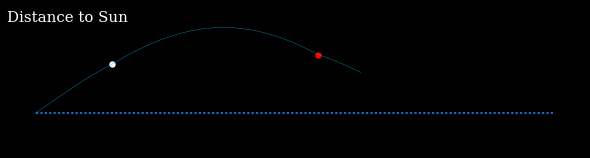

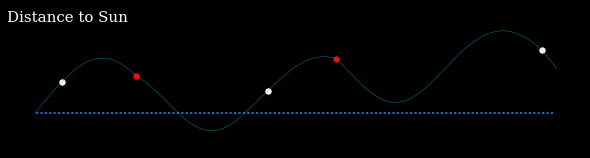

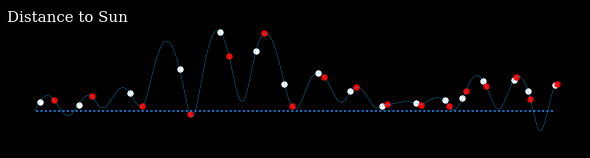

In [20]:
%time ax = t.show_orbit_stats(**t.heliocentric_radius(epoch=t.traj[2].dep_t + 30))
%time ax = t.show_orbit_stats(**t.heliocentric_radius(epoch=t.traj[5].dep_t + 30))
%time ax = t.show_orbit_stats(**t.heliocentric_radius())
ax.get_xlim(), ax.get_ylim()

Wall time: 73.7 ms
Wall time: 74.2 ms
Wall time: 71.7 ms


((58842.926954533577, 64812.771265346288),
 (-4.8851121610480863, 5.7055407753442289))

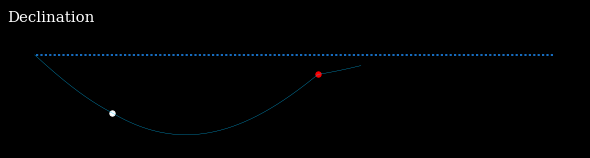

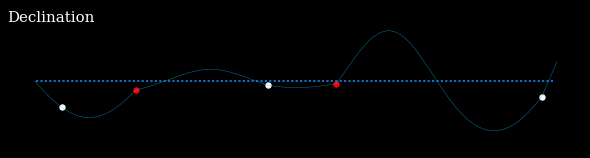

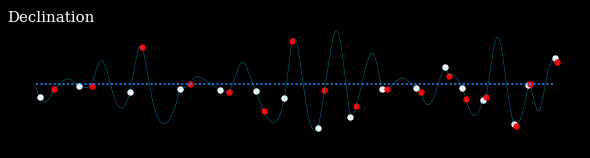

In [21]:
%time ax = t.show_orbit_stats(**t.declination(epoch=t.traj[2].dep_t + 30))
%time ax = t.show_orbit_stats(**t.declination(epoch=t.traj[5].dep_t + 30))
%time ax = t.show_orbit_stats(**t.declination())
ax.get_xlim(), ax.get_ylim()

Wall time: 19.1 ms
Wall time: 21.1 ms
(59108.029630048462, 59510.717755048463) (0.94999999999999996, 1.05)
(59108.029630048462, 59510.717755048463) (-0.050000000000000003, 0.050000000000000003)


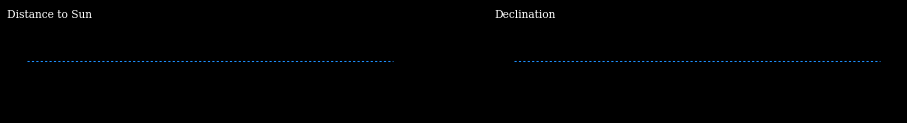

In [22]:
# simulate look on the 1st frame
fig = plt.figure(facecolor='black', figsize=(16, 2))
ax1 = fig.add_subplot(1,2,1, facecolor='black')
%time t.show_orbit_stats(ax=ax1, **t.heliocentric_radius(epoch=t.traj[0].dep_t))
ax2 = fig.add_subplot(1,2,2, facecolor='black')
%time t.show_orbit_stats(ax=ax2, **t.declination(epoch=t.traj[0].dep_t))
print(ax1.get_xlim(), ax1.get_ylim())
print(ax2.get_xlim(), ax2.get_ylim())
#t.show_orbit_stats(ax=ax1, **t.heliocentric_radius(epoch=t.traj[2].dep_t))
#t.show_orbit_stats(ax=ax2, **t.declination(epoch=t.traj[2].dep_t));

Reference frames for inspecting the rendering of different aspect of the animation.

In [23]:
# plot and save just the reference image
#t = traj_anim(spice)
#%time ax,*_ = t.show(t.traj[-1].arr_t, pixel_height=1080)
#ax.get_figure().savefig('save.png')

Wall time: 207 ms
Wall time: 241 ms
Wall time: 157 ms


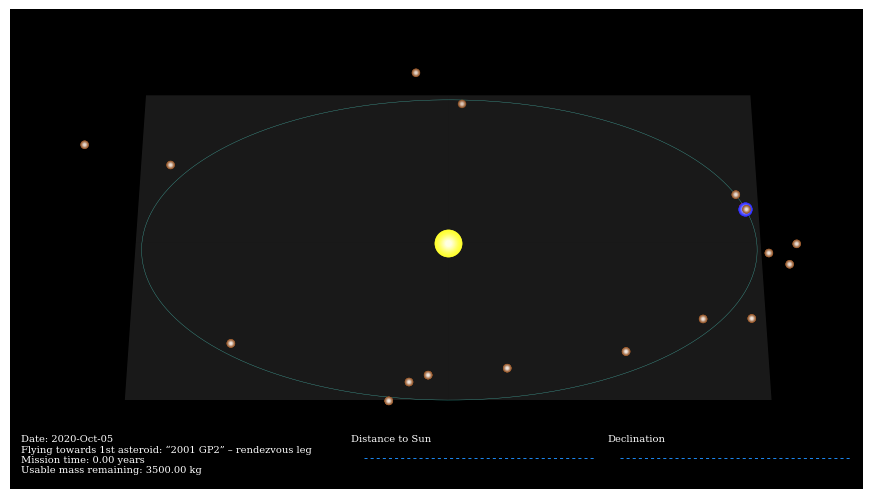

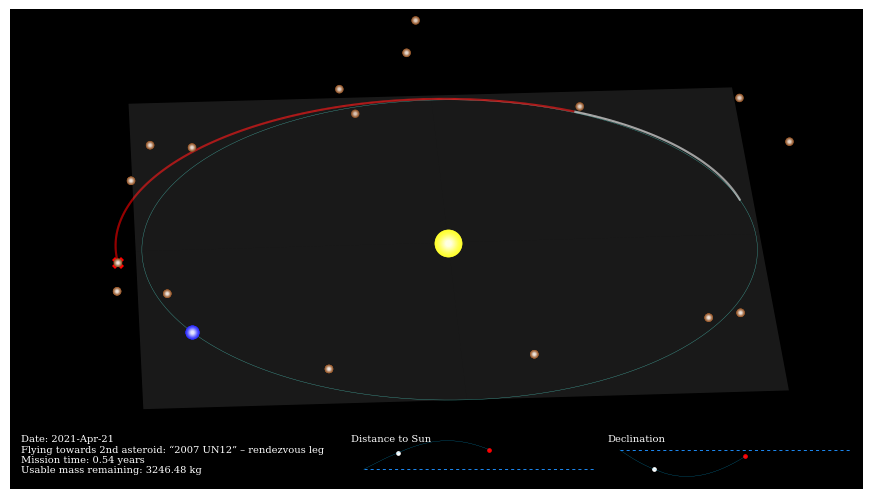

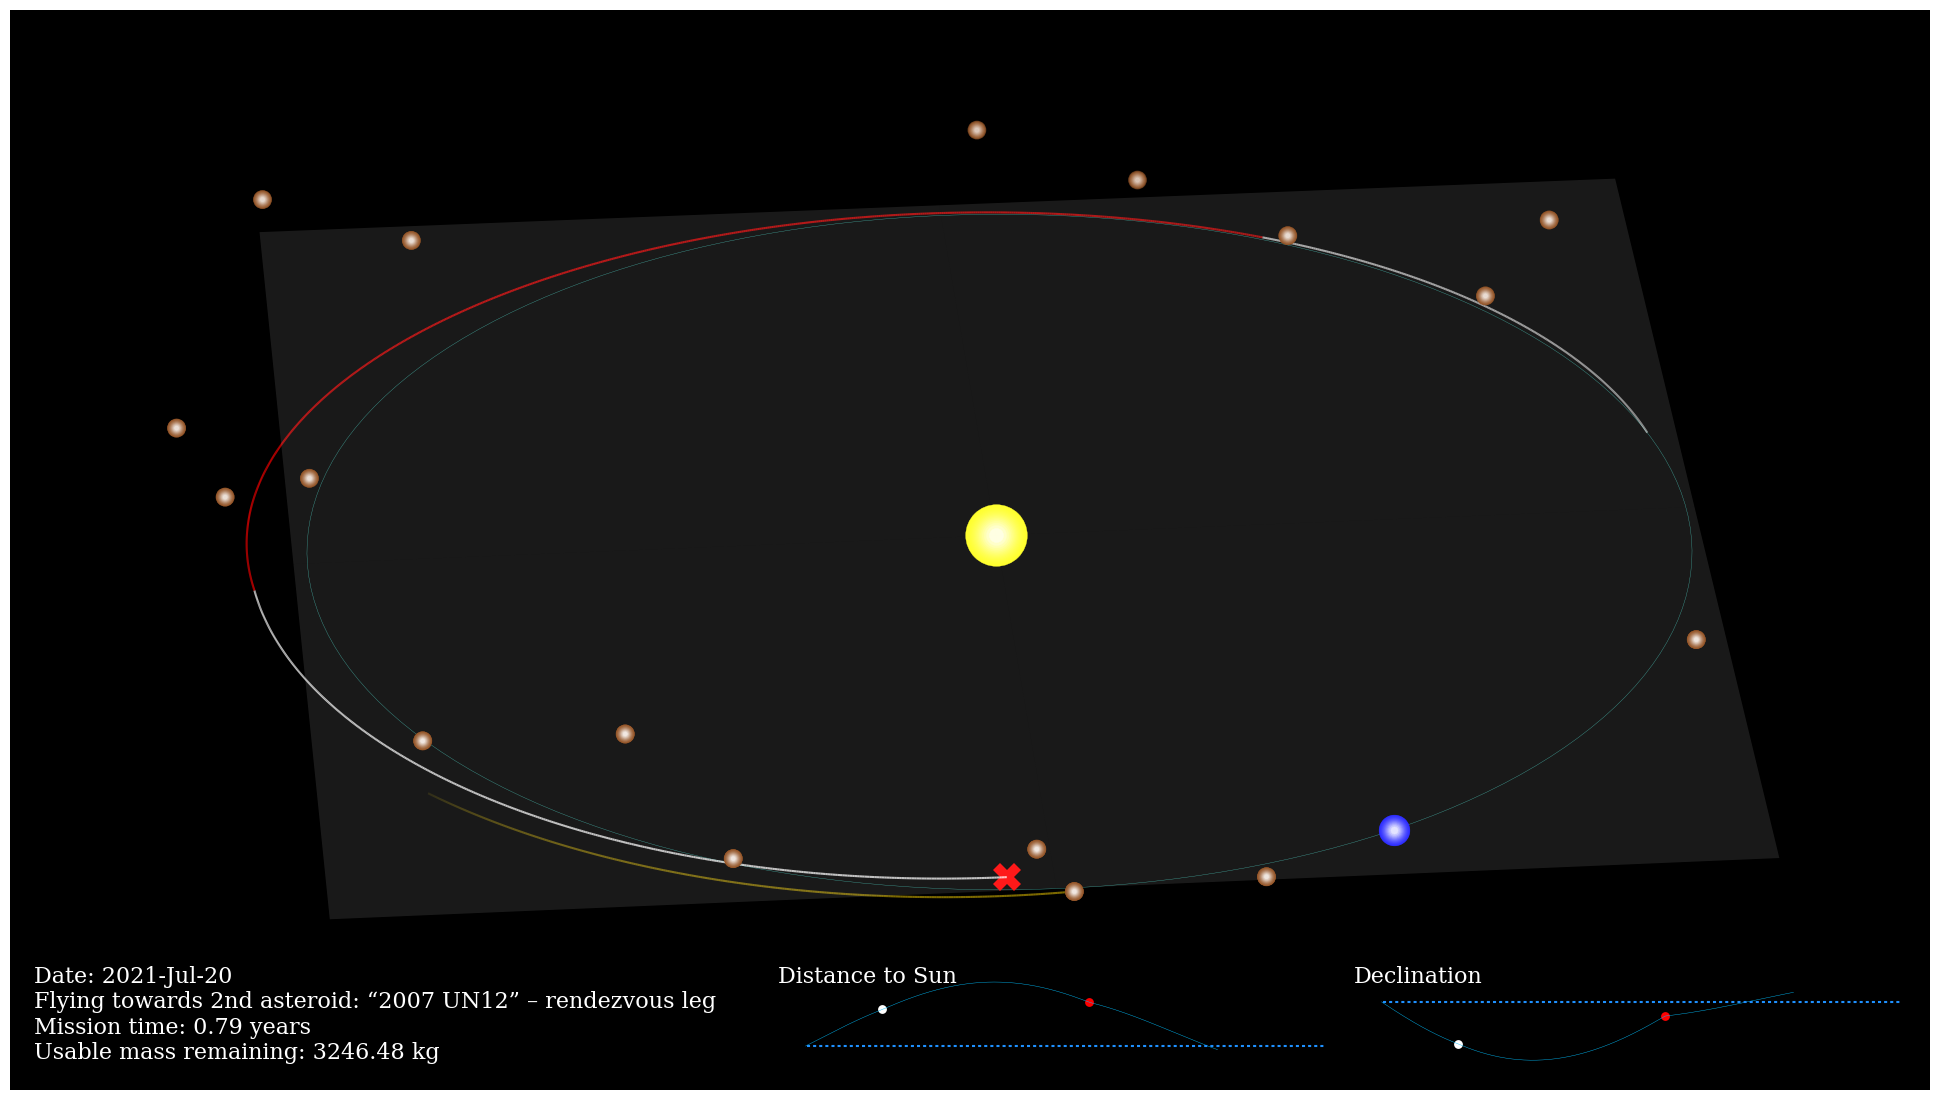

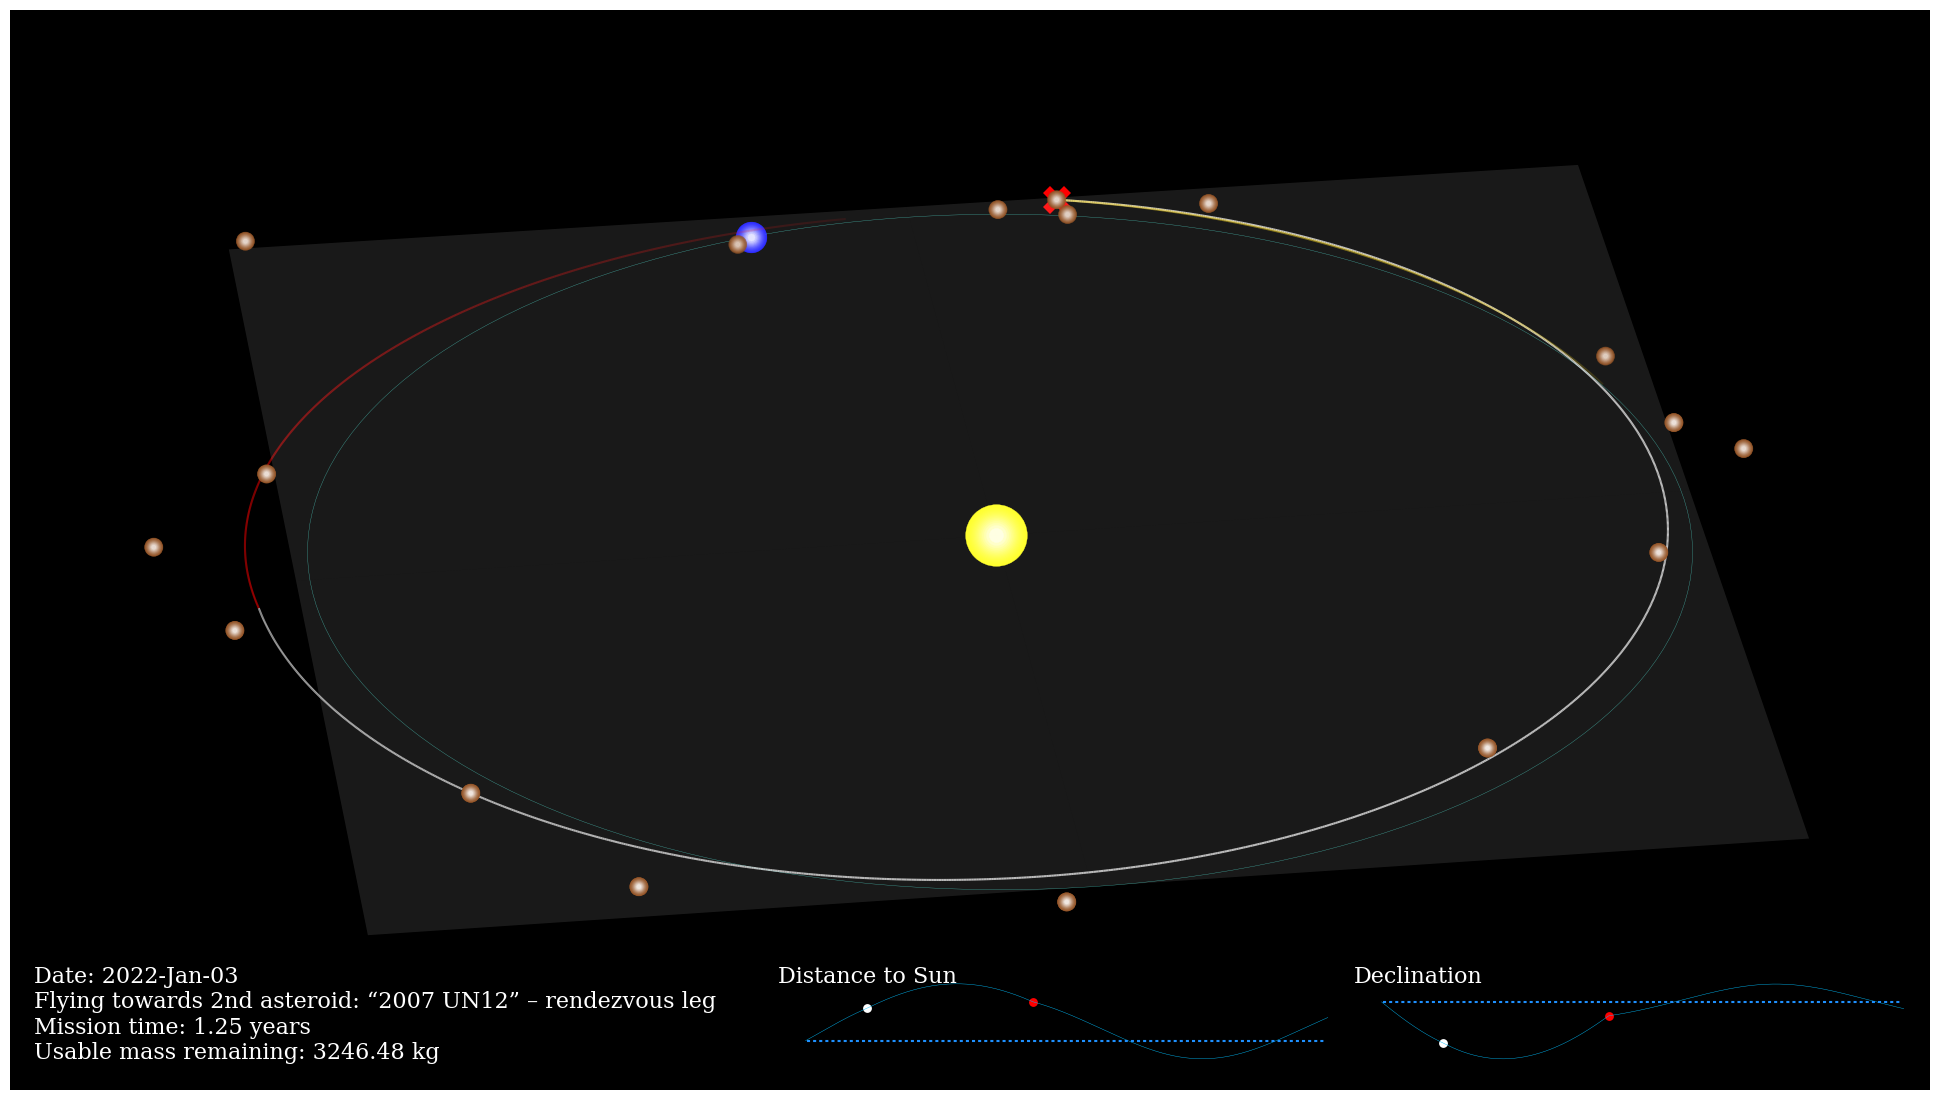

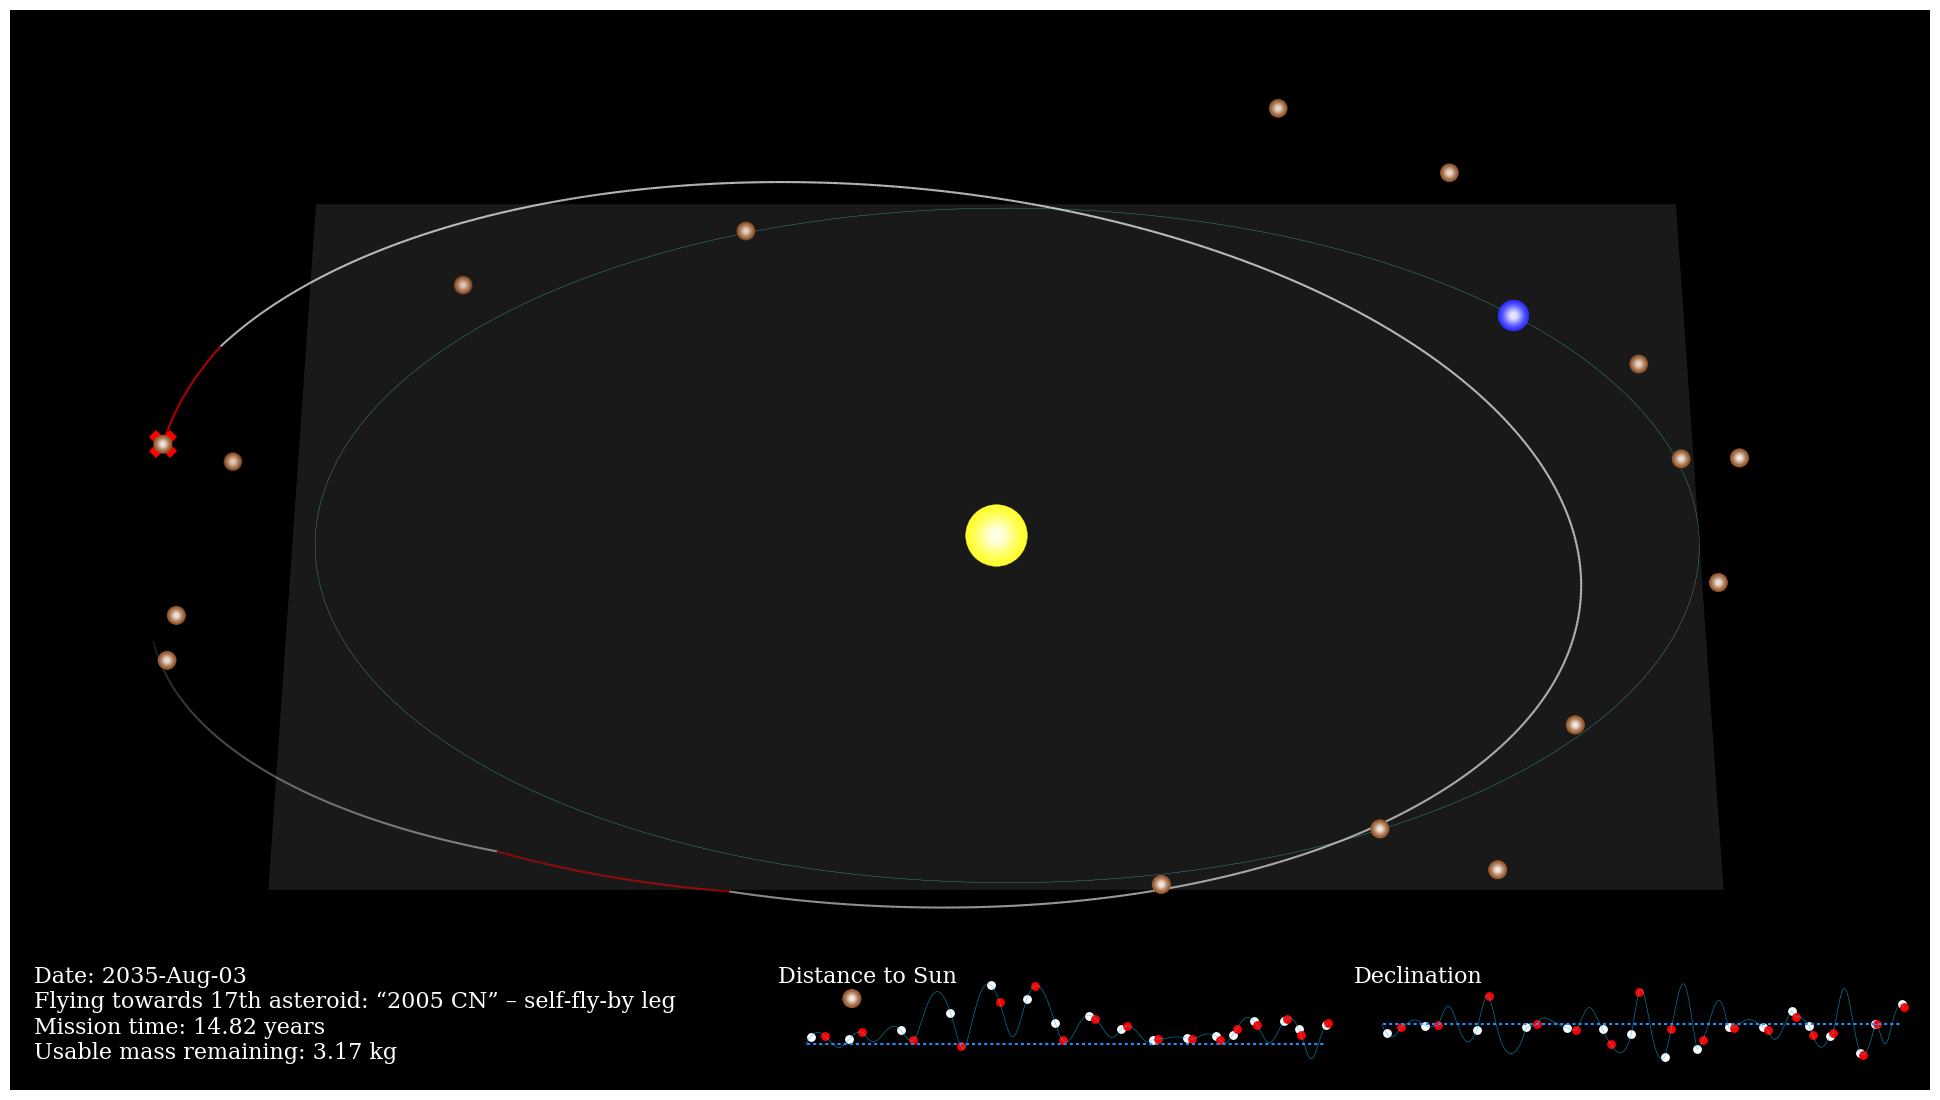

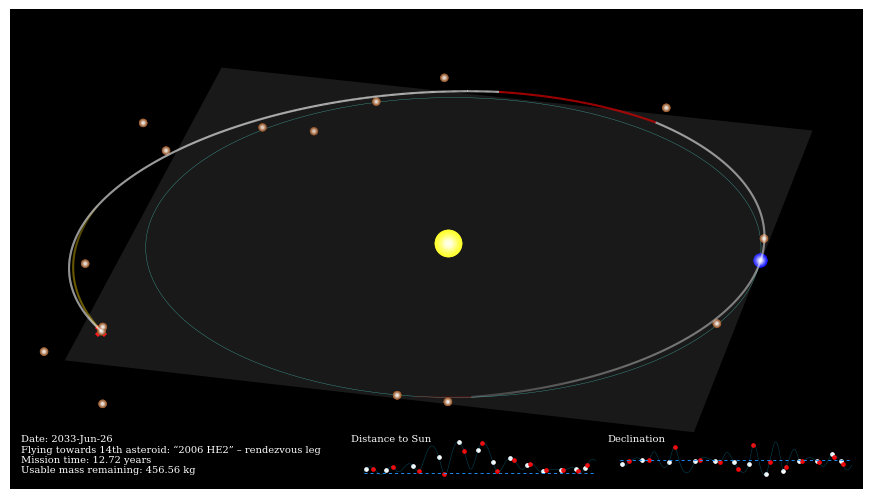

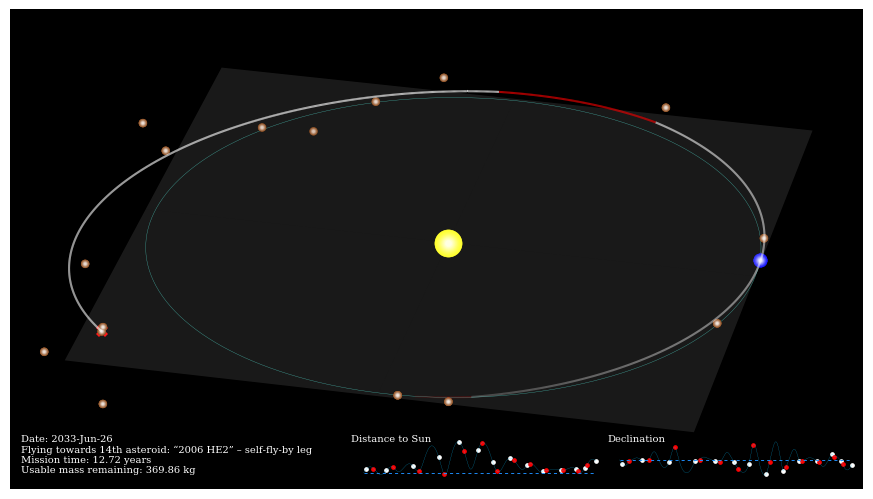

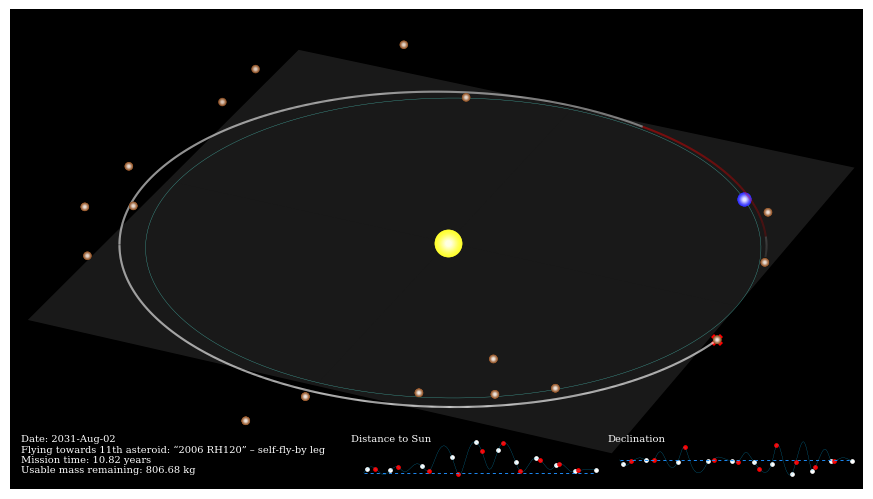

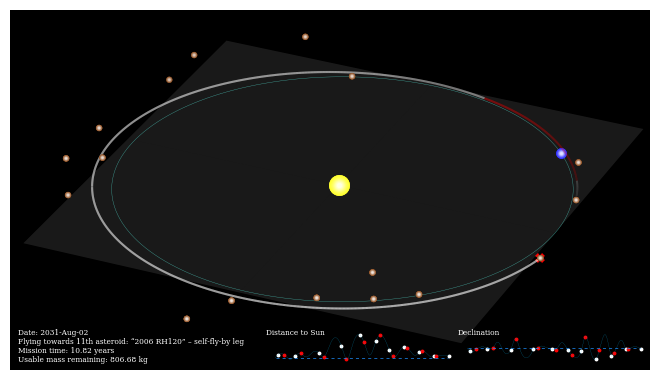

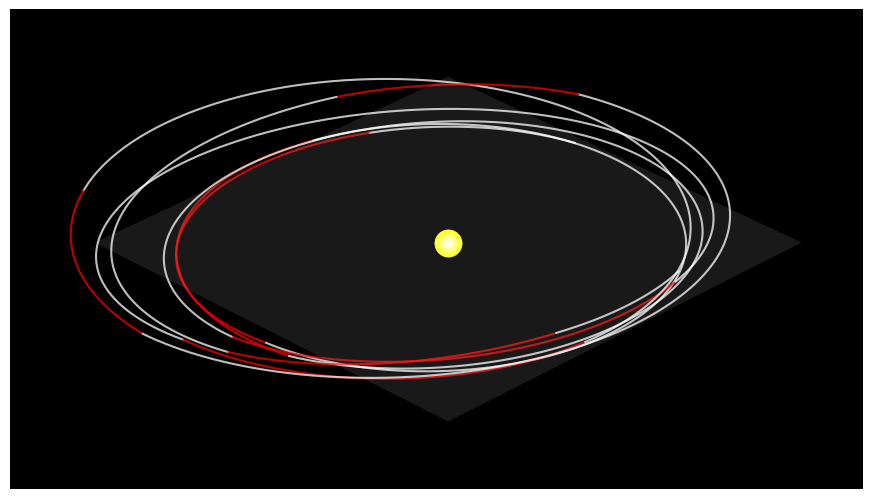

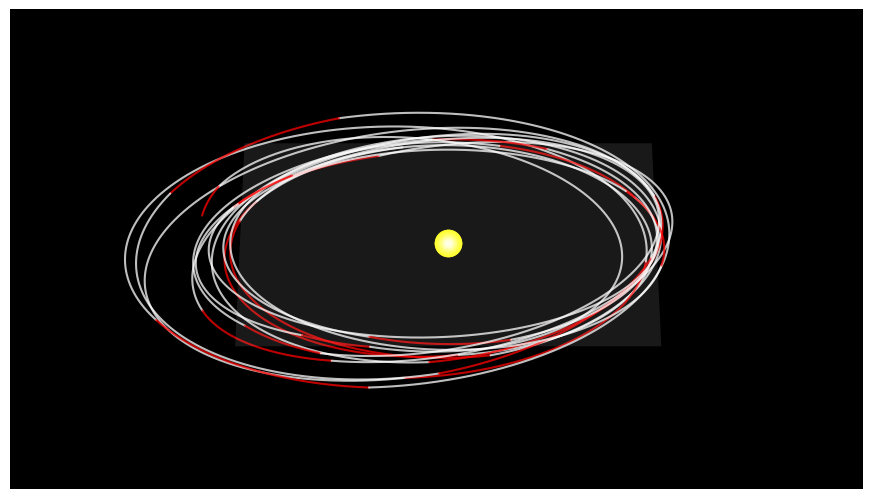

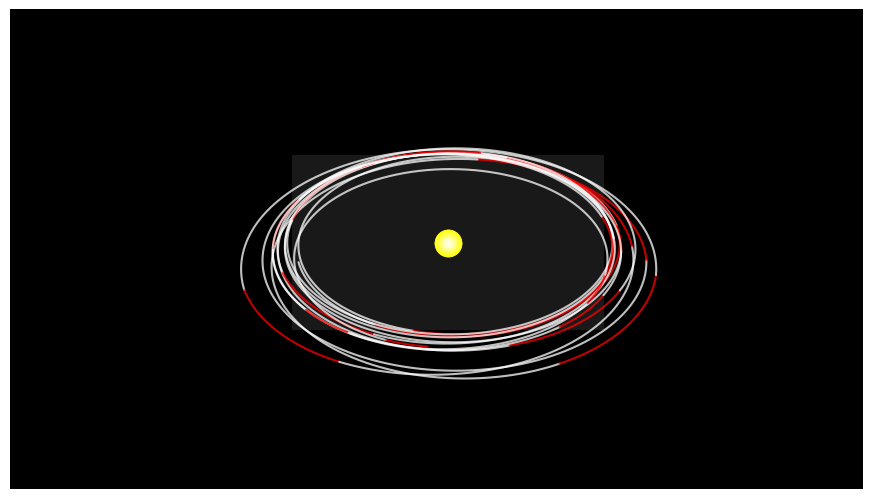

In [24]:
t = traj_anim(spice)
#t.marker_gradient = False

# the animation's very first frame (0 mission time, all mass available)
%time ax,*_ = t.show(t.leg_start[0])

# first asteroid fully scored
ax,*_ = t.show(t.leg_start[2])

# still attempting to meet 2nd asteroid
# flight time now >1 year (2d plots now shrinking to accomodate new data)
# also: clearly inspecting the trails left by arrival asteroids up to the rendezvous with them
ax,*_ = t.show(t.traj[2].dep_t+90, pixel_height=1080)
ax,*_ = t.show(t.traj[2].arr_t-.1, pixel_height=1080)
#ax.get_figure().savefig('save.png')

# end of the trajectory -- final frame of the 1st animation
# (mass+500 and mission time as reported by: final_mass(spice)-MASS_MIN, tof(spice) * DAY2YEAR)
%time ax,*_ = t.show(t.traj[-1].arr_t, pixel_height=1080)
ax.get_figure().savefig('save.png')

# spotting change in contextual information as spacecraft begins a self-fly-by leg
ax,*_ = t.show(t.leg_start[27]-.1)
ax,*_ = t.show(t.leg_start[27])

# leg to one of the asteroids with the largest name (and score>10), comparing auto-scalings
# also: ecliptic plane over the lower right plots
ax,*_ = t.show(t.leg_start[21])
ax,*_ = t.show(t.leg_start[21], pixel_height=360)

# frames from the final animation
%time ax,*_ = t.show(0.5)
ax,*_ = t.show(1.0)
ax,*_ = t.show(2.0)

----

# Displaying animation in the notebook

Render a few seconds of video, and display them on the notebook.<br>
Example: [Embedding Matplotlib Animations in Jupyter Notebooks](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/).

In [ ]:
plt.rcParams['animation.html'] = 'html5'
from IPython.display import HTML

In [ ]:
t = traj_anim(spice)
t.marker_gradient = False # (for faster rendering)

vid_quality = dict(pixel_height=480, fps=10)
#vid_quality = dict(pixel_height=720, fps=20)
#vid_quality = dict(pixel_height=1080, fps=30)

render_slice = slice(None, 10) # first 10 seconds
#render_slice = slice(5, 20) # 5s to 20s
#render_slice = slice(1*60+58, 2*60 + 8) # 1:58 to 2:08, at the switch between animations
#render_slice = slice(1*60+58, None) # see the whole second/final animation

t_anim = t.create_anim(render_slice=render_slice, **vid_quality)
%time HTML(t_anim.to_html5_video())

In [ ]:
# f = open('test.mp4.html', 'w')
# %time f.write(t_anim.to_html5_video())
# f.close()

----

# Encoding for YouTube

Save animation as an .MP4 file, properly encoded for upload to YouTube.

In [39]:
traj_to_show = spice

In [40]:
fname = 'test'

In [41]:
vid_args = dict(pixel_height=480, fps=20)
#vid_args = dict(pixel_height=720, fps=30)
#vid_args = dict(pixel_height=1080, fps=30)
#vid_args = dict(pixel_height=1080, fps=60)

fname += '_%dp%d' % (vid_args['pixel_height'], vid_args['fps'])

Rendering:   0%|                                                                           | 1/3100 [00:00<18:15,  2.83it/s]

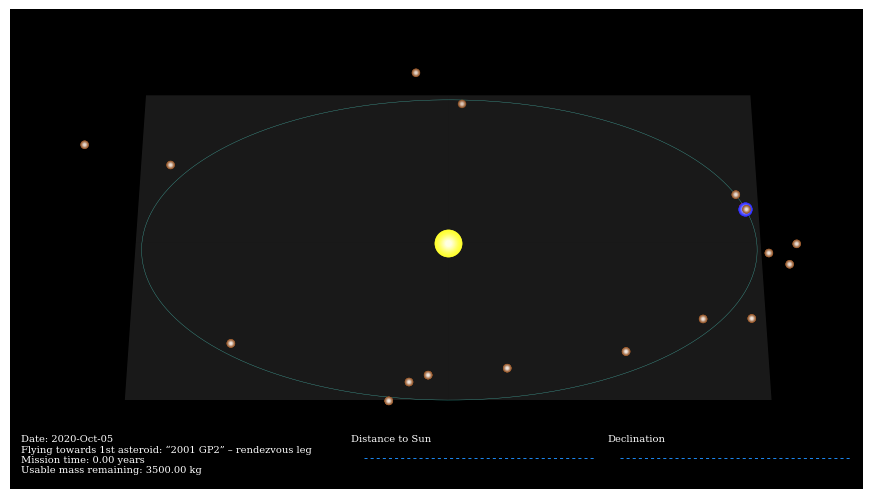

In [42]:
t = traj_anim(traj_to_show)
#t.marker_gradient = False
t_anim = t.create_anim(**vid_args)

Parameterizing FFMpeg

* [Recommended upload encoding settings - YouTube Help](https://support.google.com/youtube/answer/1722171)
* [Encoding videos for YouTube with FFMpeg](https://www.virag.si/2015/06/encoding-videos-for-youtube-with-ffmpeg/)
* [Encode/H.264 – FFmpeg](https://trac.ffmpeg.org/wiki/Encode/H.264)
* [ffmpeg Documentation, 5.4 Main options](https://ffmpeg.org/ffmpeg.html#Main-options)

In [43]:
extra_args=[
    # set video codec to H.264
    '-vcodec', 'libx264',
    # set video quality. Lower number means higher quality.
    # 0 results in a lossless output
    # See: https://trac.ffmpeg.org/wiki/Encode/H.264#LosslessH.264
    '-crf', '0',
#    '-crf', '17', # output that is roughly "visually lossless" but not technically lossless
#    '-crf', '21', # a reasonable default which will create videos with bitrates as per guideline
    # maximum 2 B-frames as per guideline
    '-bf', '2',
    # closed GOP as per guideline
    '-flags', '+cgop',
    # chroma subsampling 4:2:0 as per guideline
    '-pix_fmt', 'yuv420p',
    # put MOOV atom at the front of the file
    '-movflags', 'faststart',
    ]

Define metadata tags

In [44]:
title = "GTOC5: Lambert model trajectory exploring %d asteroids" % score(traj_to_show)
comment = "Score: %.1f\nFinal mass (kg): %s\nTime of flight (years): %s\nResource rating: %s" % (
    score(traj_to_show),
    repr(final_mass(traj_to_show)),
    repr(tof(traj_to_show) * DAY2YEAR),
    repr(resource_rating(traj_to_show)))
print(title, '\n' + comment)
metadata = dict(title=title, comment=comment)

GTOC5: Lambert model trajectory exploring 17 asteroids 
Score: 17.0
Final mass (kg): 503.17005813629083
Time of flight (years): 14.824982263414686
Resource rating: 0.0016809741417111957


## Save animation as an MP4 video

In [47]:
t_anim.save(fname + '.mp4', writer='ffmpeg', fps=vid_args['fps'], dpi=100, extra_args=extra_args, metadata=metadata)

Rendering: 3147it [25:24,  4.21it/s]                                                                                        

## Add soundtrack

In [48]:
from os.path import exists
from urllib.request import urlretrieve
from subprocess import call

Download audio file:

> Frédéric Chopin, Waltz in C-sharp minor, Op. 64 No. 2, Harald Vetter (Piano)<br>
  Available at: http://imslp.org/wiki/Special:ReverseLookup/456980

In [49]:
soundtrack_file = 'IMSLP456980-PMLP02373-Chopin_WalzerOp64_Nr2_cis_Moll.mp3'

In [50]:
if not exists(soundtrack_file):
    urlretrieve('http://imslp.nl/imglnks/usimg/4/41/' + soundtrack_file, filename=soundtrack_file);

Trim audio file down to a length of 2 min. 20.8 sec., and apply a [fade-out](https://www.ffmpeg.org/ffmpeg-filters.html#afade-1) effect over the last 5 seconds. Save result into an AAC-encoded .m4a file [[1](https://trac.ffmpeg.org/wiki/Encode/AAC), [2](https://www.ffmpeg.org/ffmpeg-codecs.html#aac), [3](https://trac.ffmpeg.org/wiki/Encode/HighQualityAudio)], with all [metadata removed](https://superuser.com/questions/441361/strip-metadata-from-all-formats-with-ffmpeg).

In [51]:
if not exists(soundtrack_file[:-4] + '.m4a'):
    call('ffmpeg -i %s.mp3 -map_metadata -1 -ss 0 -t 140.8 -af afade=t=out:st=135.8:d=5 -c:a aac -b:a 320k %s.m4a -y' % (
        soundtrack_file[:-4], soundtrack_file[:-4]))

Add soundtrack to the video [[1](https://stackoverflow.com/questions/11779490/how-to-add-a-new-audio-not-mixing-into-a-video-using-ffmpeg)].

In [52]:
call(['ffmpeg',
      '-i', '%s.mp4' % fname,
      '-i', soundtrack_file[:-4] + '.m4a',
      '-codec', 'copy',
      '%s+audio.mp4' % fname,
      '-y'
     ])

0

## Generating custom thumbnails

A pair of images that can be used on YouTube to give the video a custom thumbnail.

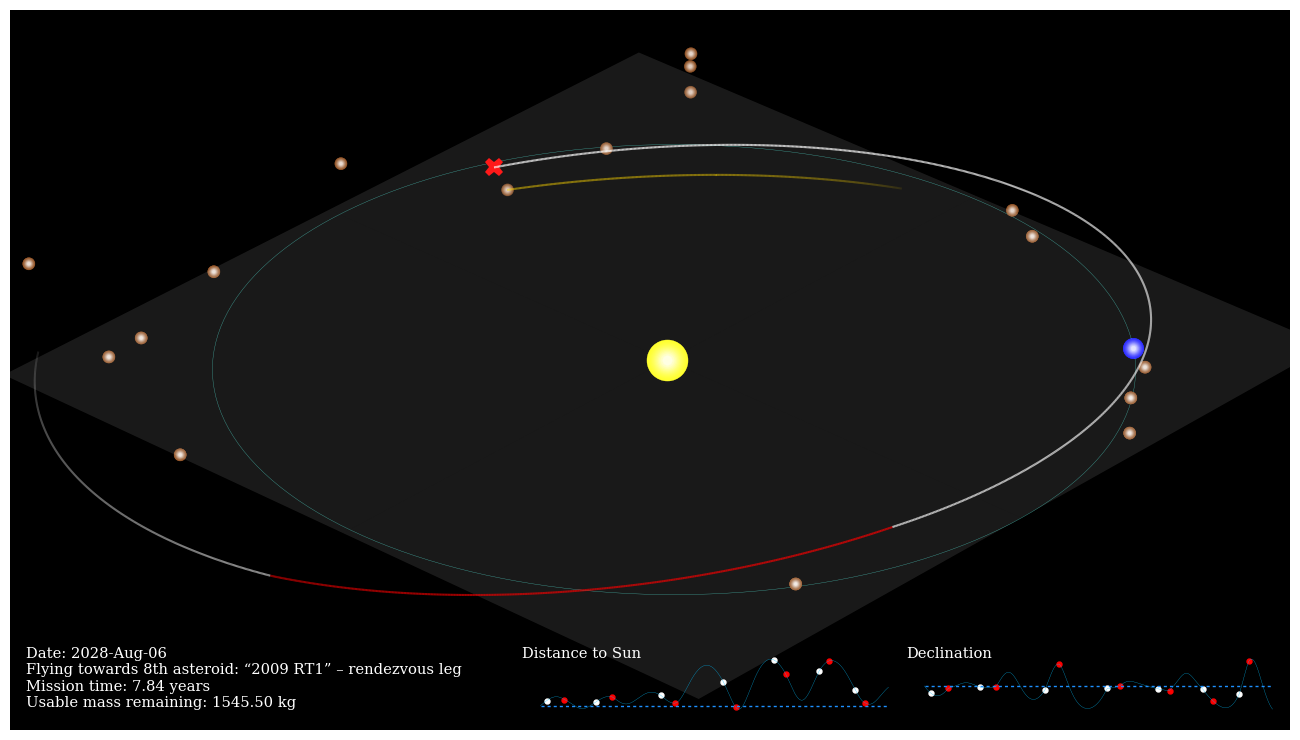

In [26]:
t = traj_anim(traj_to_show)
# find epoch corresponding to the 64.5 seconds mark (with full trajectory being animated over 122 seconds)
epoch = t.traj[0].dep_t +  (t.traj[-1].arr_t - t.traj[0].dep_t) * (64.5 / 122)

ax,*_ = t.show(epoch, pixel_height=720)
#ax,*_ = t.show(epoch, pixel_height=1080)
#ax,*_ = t.show(epoch, pixel_height=2160) # (4k)
ax.get_figure().savefig('thumbnail.1.png')

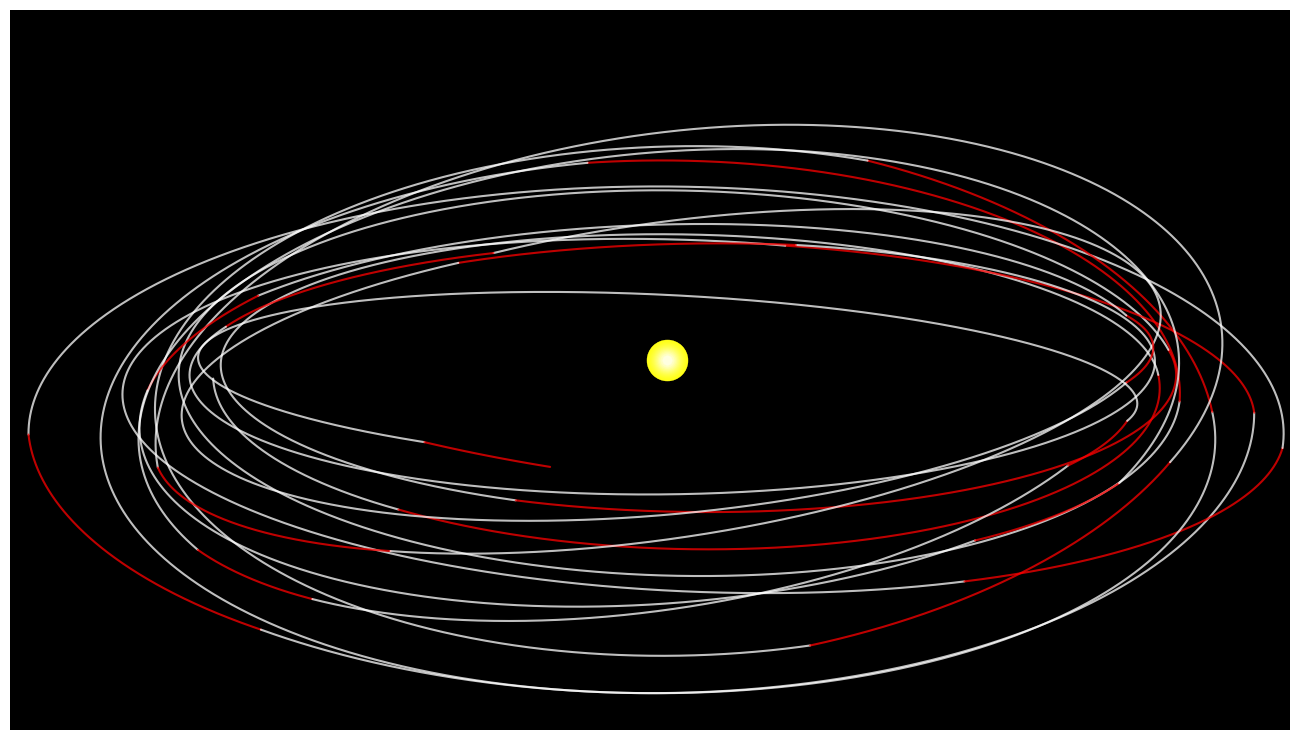

In [27]:
t = traj_anim(traj_to_show)
ax,*_ = t.show(1.0, pixel_height=720)
#ax,*_ = t.show(1.0, pixel_height=1080)

ax.view_init(elev=30, azim=95)
ax.set_xlim3d(-.76, .76)
ax.set_ylim3d(-.76, .76)
ax.set_zlim3d(-0.11, 0.11)

# remove plane of the ecliptic
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
next(c for c in ax.get_children() if isinstance(c, Poly3DCollection)).remove()
        
ax.get_figure().savefig('thumbnail.2.png')

----

# Creating animated GIFs

Animated GIFs created with [ImageMagick](https://www.imagemagick.org/), via Matplotlib's [`ImageMagickFileWriter`](http://matplotlib.org/api/_as_gen/matplotlib.animation.ImageMagickFileWriter.html#matplotlib.animation.ImageMagickFileWriter). Usage examples: [[1](http://eli.thegreenplace.net/2016/drawing-animated-gifs-with-matplotlib/), [2](http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/), [3](http://stackoverflow.com/a/42565258)].

In [ ]:
plt.rcParams['animation.convert_path'] = 'C:/Program Files/ImageMagick-7.0.5-Q16/magick.exe'

In [ ]:
t = traj_anim(traj_to_show)
t.show_extra_info = False
render_slice = slice(64.5 - 2.5, 64.5 + 2.5) # picking 5 seconds of the video, centered at the 64.5 second mark
t_anim = t.create_anim(pixel_height=360, fps=40, render_slice=render_slice)
#t_anim = t.create_anim(pixel_height=480, fps=40, render_slice=render_slice)
%time t_anim.save('traj_video.gif', writer='imagemagick', fps=20)  # lower fps to reduce animation speed

----

# Profiling

Profile code over frames from randomly sampled epochs.

In [ ]:
def rand_frames(t, n=1000):
    "generate `n` frames, of randomly chosen epochs, onto the same figure/axes."
    ax = None
    epochs = t.traj[0].dep_t + np.random.random(n) * (t.traj[-1].arr_t - t.traj[0].dep_t)
    for epoch in epochs:
        ax = t.show(epoch, ax=ax, pixel_height=1080)
    return ax

In [ ]:
t = traj_anim(spice)
#t.marker_gradient = False
t.marker_gradient = True
%prun -s cumulative ax = rand_frames(t, n=100)
#%prun -s cumulative ax = rand_frames(t, n=1000)
ax[0].get_figure().clear()

Profile the last 14 seconds of the fist animation.

In [ ]:
t = traj_anim(spice)
t_anim = t.create_anim(pixel_height=1080, fps=10, render_slice=slice(1*60+50, 2*60 + 4))
%prun -s cumulative HTML(t_anim.to_html5_video())

----

# Watermark

Watermark of the environment in which video was generated.

In [1]:
%load_ext watermark
%watermark -v -m -p PyKEP,numpy,tqdm,matplotlib,seaborn,IPython,jupyter
# https://github.com/rasbt/watermark

CPython 3.5.3
IPython 5.3.0

PyKEP {'minor': 3, 'major': 1, 'bugfix': 9}
numpy 1.12.1
tqdm 4.11.2
matplotlib 2.0.0
seaborn 0.7.1
IPython 5.3.0
jupyter 1.0.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


[FFmpeg](https://ffmpeg.org/about.html)

In [2]:
!ffmpeg -version

ffmpeg version N-85266-g1229007 Copyright (c) 2000-2017 the FFmpeg developers
built with gcc 6.3.0 (GCC)
configuration: --enable-gpl --enable-version3 --enable-cuda --enable-cuvid --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-nvenc --enable-avisynth --enable-bzlib --enable-fontconfig --enable-frei0r --enable-gnutls --enable-iconv --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libfreetype --enable-libgme --enable-libgsm --enable-libilbc --enable-libmodplug --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librtmp --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-lzma --enable-zlib
libavutil      55. 59.100 

[ImageMagick](https://www.imagemagick.org/)

In [3]:
!magick -version

Version: ImageMagick 7.0.5-4 Q16 x64 2017-03-25 http://www.imagemagick.org
Copyright: Copyright (C) 1999-2015 ImageMagick Studio LLC
License: http://www.imagemagick.org/script/license.php
Visual C++: 180040629
Features: Cipher DPC Modules OpenMP 
Delegates (built-in): bzlib cairo flif freetype jng jp2 jpeg lcms lqr openexr pangocairo png ps rsvg tiff webp xml zlib


----

Generate the Table of Contents

In [4]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

----